# Trabajo Práctico Integrador - Visión por Computadora II
Carrera de Especialización en Inteligencia Artificial - FIUBA

**Integrantes:**
- Juan Ruiz Otondo
- Gonzalo Fernández
- Maria Fabiana Cid

**Objetivo:** Realizar un modelo para la clasificación de residuos para reciclaje basándose en el dataset [TrashNet](https://www.kaggle.com/datasets/feyzazkefe/trashnet).

## Requerimientos
Requisitos para la correcta ejecución del notebook:

- Entorno virtual de python con paquetes instalados, posible mediante la ejecución de los siguientes comandos:

```bash
python -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt
```

- Credenciales de kaggle para descarga del dataset. Más información en el README del siguiente repositorio: https://github.com/Kaggle/kagglehub

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 21.9 MB/s eta 0:00:00


In [2]:
from collections import Counter
import copy
import os
import kagglehub
import matplotlib.pyplot as plt
import optuna
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from PIL import Image
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import datasets, transforms
from torchvision.models import ResNet18_Weights, resnet18
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Modelo Elegido: EfficientNet-B0

EfficientNet-B0 es una arquitectura de red neuronal convolucional (CNN) diseñada para lograr alta precisión usando menos parámetros y menos cómputo que otras redes tradicionales.
- Muy eficiente: ideal para dispositivos móviles o proyectos con pocos recursos
- Usa Batch Normalization, Swish activations y depthwise separable convolutions
- Basado en MobileNetV2, pero mejorado
- Escalable a modelos más grandes (B1, B2, ..., B7)

Razones por las que se seleccionó EfficientNet-B0
- TrashNet es un dataset relativamente pequeño
- EfficientNet-B0 tiene pocos parámetros, lo que evita overfitting
- Ofrece alta precisión con bajo costo computacional

### Carga y preprocesamiento del dataset

Carga y preprocesamiento del dataset TrashNet.

In [9]:
dataset_path = kagglehub.dataset_download("feyzazkefe/trashnet", force_download=False)
print("Path to dataset files:", dataset_path)
dataset_path = os.path.join(dataset_path, "dataset-resized")

full_dataset = datasets.ImageFolder(root=dataset_path)
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")

Path to dataset files: /kaggle/input/trashnet
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


En el EDA se detectó un desbalance de clases (la clase "trash" no esta tan representada como el resto). Se corrige mediante la aplicación de data augmentation.

Con este objetivo, definimos una clase que hereda de la clase base dataset para metermitir aplicaciones orientadas para cada clase.

In [10]:
class ClassAugmentDataset(Dataset):
    def __init__(self, samples, default_transform):
        self.samples = samples
        self.default_transform = default_transform

    def __getitem__(self, index):
        image, label = self.samples[index]
        return self.default_transform(image), label

    def __len__(self):
        return len(self.samples)

Definimos la una transformación para la clase "trash" con data augmentation y otra default. Para validación no se aplica ningun tipo de data augmentation.

In [11]:
train_transform = transforms.Compose(
    [
        # transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(25),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Normalize([0.5] * 3, [0.5] * 3),
    ]
)

test_transform = transforms.Compose(
    [
        # transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Normalize([0.5] * 3, [0.5] * 3),
    ]
)

1. División del dataset en datos para entrenamiento y datos de validación.
2. Aplicación de transformaciones definidas previamente.
3. Creación de sampler para datos de training
4. Creación de data loaders.

In [12]:
def get_dataloaders(
    dataset, train_transform, val_transform, batch_size, use_sampler=False
):
    """Get dataloaders for training and validation."""
    train_samples, val_samples = torch.utils.data.random_split(dataset, [0.8, 0.2])

    train_dataset = ClassAugmentDataset(
        train_samples, default_transform=train_transform
    )
    val_dataset = ClassAugmentDataset(val_samples, default_transform=val_transform)

    train_labels = [label for _, label in train_samples]
    class_counts = Counter(train_labels)
    class_weights = {
        cls: len(train_labels) / count for cls, count in class_counts.items()
    }
    sample_weights = [class_weights[lbl] for lbl in train_labels]

    train_sampler = None
    if use_sampler:
        train_sampler = WeightedRandomSampler(
            sample_weights, num_samples=len(sample_weights), replacement=True
        )

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=4
    )
    return train_loader, val_loader

### Definición del modelo EfficientNet-B0

In [13]:
def create_empty_model(num_classes):
    model = timm.create_model("efficientnet_b0", pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    return model


model = create_empty_model(num_classes=num_classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

### Entrenamiento y validación del modelo

Definición del esquema de entrenamiento y validación.

In [14]:
def train_validate(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=10,
    scheduler=None,
    verbose=False,
):
    """Train and validate the model."""
    model.to(device)
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        preds, targets = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = accuracy_score(targets, preds)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss = 0.0
        val_preds, val_targets = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_targets, val_preds)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if verbose:
            print(
                f"Epoch {epoch+1}/{epochs} | "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
            )

        if val_acc > best_acc:  # save the best model
            precision = precision_score(
                val_targets, val_preds, average="macro", zero_division=0
            )
            recall = recall_score(
                val_targets, val_preds, average="macro", zero_division=0
            )
            f1 = f1_score(val_targets, val_preds, average="macro", zero_division=0)
            cm = confusion_matrix(val_targets, val_preds)
            cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)

            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            metrics = {
                "precision": precision,
                "recall": recall,
                "f1_score": f1,
                "accuracy": val_acc,
                "confusion_matrix": cm_normalized,
                "val_targets": val_targets,
                "val_preds": val_preds,
            }

        if scheduler is not None:
            scheduler.step()

    if verbose:
        print(f"Best accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accuracies, val_accuracies, metrics

### Entrenamiento y validation sin data augmentation
Ejecución del entrenamiento y validación:

In [15]:
train_loader, val_loader = get_dataloaders(
    full_dataset, train_transform, test_transform, batch_size=32, use_sampler=False
)

model = create_empty_model(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model, train_losses, val_losses, train_accuracies, val_accuracies, metrics = (
    train_validate(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        epochs=15,
        scheduler=scheduler,
        verbose=True,
    )
)

Epoch 1/15 | Train Loss: 0.0388, Train Acc: 0.5999 | Val Loss: 0.9262, Val Acc: 0.7743
Epoch 2/15 | Train Loss: 0.0256, Train Acc: 0.7453 | Val Loss: 0.7263, Val Acc: 0.8119
Epoch 3/15 | Train Loss: 0.0214, Train Acc: 0.7735 | Val Loss: 0.6491, Val Acc: 0.8317
Epoch 4/15 | Train Loss: 0.0187, Train Acc: 0.8002 | Val Loss: 0.5925, Val Acc: 0.8416
Epoch 5/15 | Train Loss: 0.0173, Train Acc: 0.8249 | Val Loss: 0.5504, Val Acc: 0.8436
Epoch 6/15 | Train Loss: 0.0160, Train Acc: 0.8348 | Val Loss: 0.5355, Val Acc: 0.8376
Epoch 7/15 | Train Loss: 0.0152, Train Acc: 0.8536 | Val Loss: 0.5234, Val Acc: 0.8416
Epoch 8/15 | Train Loss: 0.0151, Train Acc: 0.8482 | Val Loss: 0.5143, Val Acc: 0.8396
Epoch 9/15 | Train Loss: 0.0145, Train Acc: 0.8516 | Val Loss: 0.5104, Val Acc: 0.8535
Epoch 10/15 | Train Loss: 0.0139, Train Acc: 0.8600 | Val Loss: 0.4914, Val Acc: 0.8495
Epoch 11/15 | Train Loss: 0.0136, Train Acc: 0.8665 | Val Loss: 0.4963, Val Acc: 0.8574
Epoch 12/15 | Train Loss: 0.0134, Train A

Visualización de resultados:

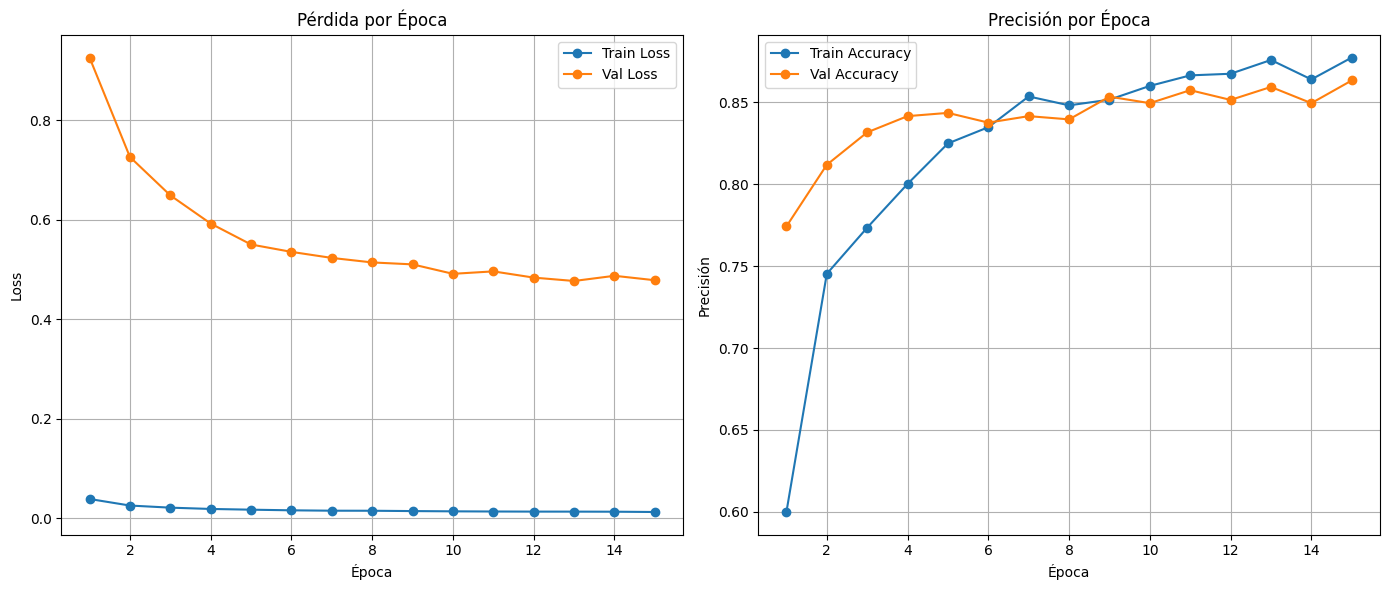

In [16]:
def get_loss_precision_plots(
    train_losses, val_losses, train_accuracies, val_accuracies, ax_loss, ax_accuracy
):
    """Plot training and validation loss and accuracy."""
    epochs_range = range(1, len(train_losses) + 1)

    ax_loss.set_title("Pérdida por Época")
    ax_loss.plot(epochs_range, train_losses, label="Train Loss", marker="o")
    ax_loss.plot(epochs_range, val_losses, label="Val Loss", marker="o")
    ax_loss.set_xlabel("Época")
    ax_loss.set_ylabel("Loss")
    ax_loss.legend()
    ax_loss.grid(True)

    ax_accuracy.set_title("Precisión por Época")
    ax_accuracy.plot(epochs_range, train_accuracies, label="Train Accuracy", marker="o")
    ax_accuracy.plot(epochs_range, val_accuracies, label="Val Accuracy", marker="o")
    ax_accuracy.set_xlabel("Época")
    ax_accuracy.set_ylabel("Precisión")
    ax_accuracy.legend()
    ax_accuracy.grid(True)


fig, axs = plt.subplots(1, 2, figsize=(14, 6))
get_loss_precision_plots(
    train_losses, val_losses, train_accuracies, val_accuracies, axs[0], axs[1]
)
fig.tight_layout()

Resultados:

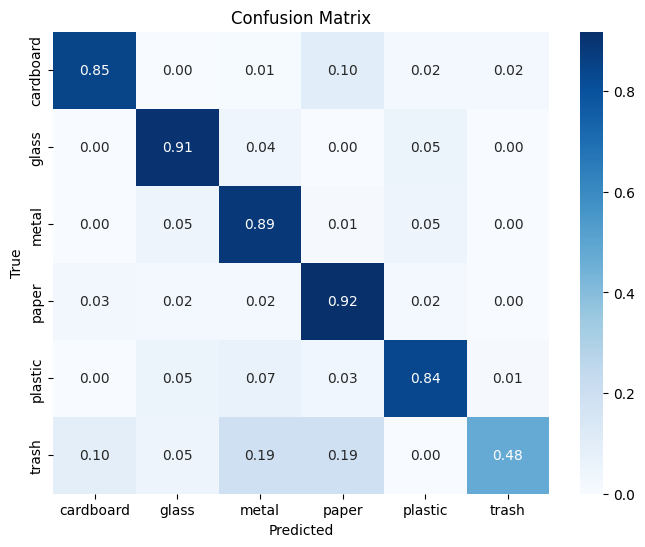

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    metrics["confusion_matrix"],
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [18]:
print("Classification report:")
print(
    classification_report(metrics["val_targets"], metrics["val_preds"], zero_division=0)
)

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       106
           1       0.88      0.91      0.89        95
           2       0.81      0.89      0.85        81
           3       0.84      0.92      0.88       110
           4       0.86      0.84      0.85        92
           5       0.77      0.48      0.59        21

    accuracy                           0.86       505
   macro avg       0.85      0.81      0.82       505
weighted avg       0.86      0.86      0.86       505



### Entrenamiento y validation con data augmentation
Definición de diferentes transformaciones y ejecución del entrenamiento y validación:

In [19]:
train_transform0 = transforms.Compose(
    [
        transforms.RandomRotation(25),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),
    ]
)

train_transform1 = transforms.Compose(
    [
        transforms.RandomRotation(25),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),
    ]
)

train_transform2 = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),
    ]
)

train_transform3 = transforms.Compose(
    [
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),
    ]
)

train_transform4 = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),
    ]
)

train_transform5 = transforms.Compose(
    [
        transforms.RandomRotation(25),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),
    ]
)

test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize([0.5] * 3, [0.5] * 3)]
)

In [20]:
train_losses_results = []
val_losses_results = []
train_accuracies_results = []
val_accuracies_results = []
metrics_results = []

for train_transform in [
    train_transform0,
    train_transform1,
    train_transform2,
    train_transform3,
    train_transform4,
]:
    train_loader, val_loader = get_dataloaders(
        full_dataset, train_transform, test_transform, batch_size=32, use_sampler=True
    )

    model = create_empty_model(num_classes=6)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    model, train_losses, val_losses, train_accuracies, val_accuracies, metrics = (
        train_validate(
            model,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            device,
            epochs=15,
            scheduler=scheduler,
            verbose=False,
        )
    )

    train_losses_results.append(train_losses)
    val_losses_results.append(val_losses)
    train_accuracies_results.append(train_accuracies)
    val_accuracies_results.append(val_accuracies)
    metrics_results.append(metrics)

Visualización de resultados:

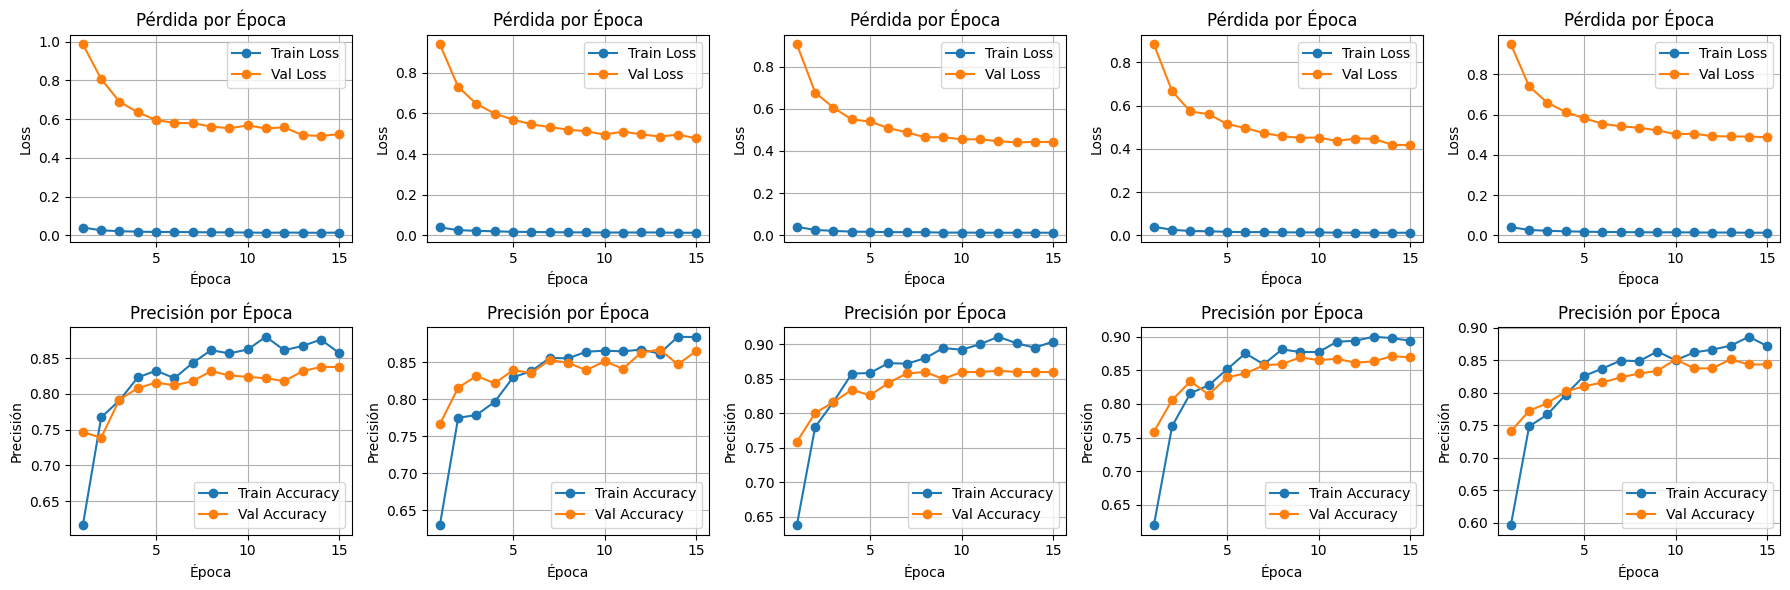

In [21]:
fig, axs = plt.subplots(2, len(train_losses_results), figsize=(18, 6))
for i, (train_losses, val_losses, train_accuracies, val_accuracies) in enumerate(
    zip(
        train_losses_results,
        val_losses_results,
        train_accuracies_results,
        val_accuracies_results,
    )
):
    get_loss_precision_plots(
        train_losses, val_losses, train_accuracies, val_accuracies, axs[0, i], axs[1, i]
    )
fig.tight_layout()

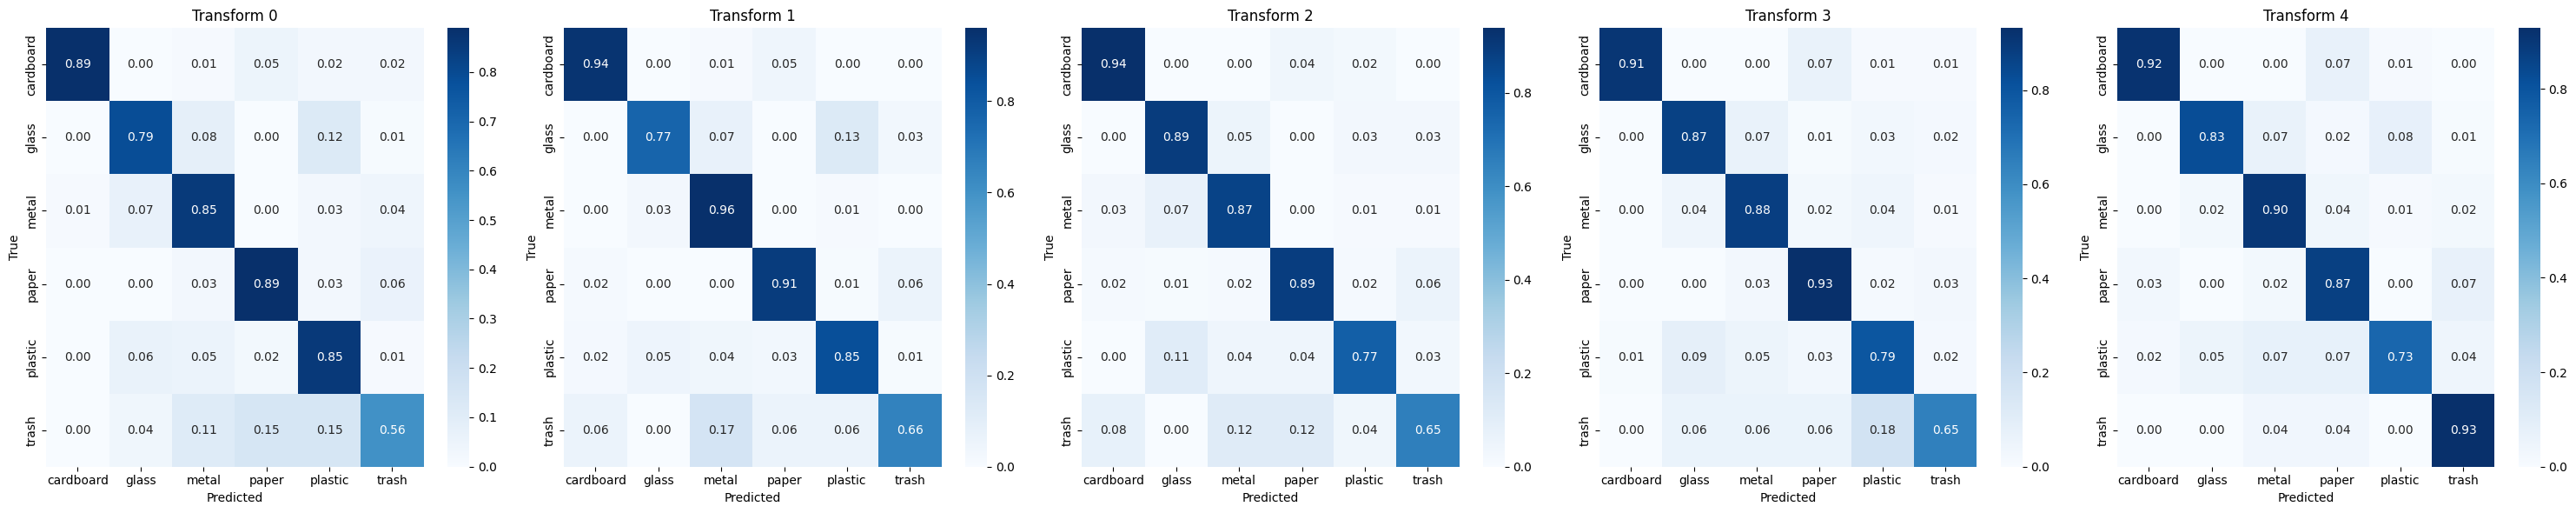

In [22]:
n = len(metrics_results)
fig, axes = plt.subplots(1, n, figsize=(6 * n, 6))

for i in range(n):
    # print(f"Transform {i}:")
    # print("Classification report:")
    # print(
    #     classification_report(
    #         metrics_results[i]["val_targets"],
    #         metrics_results[i]["val_preds"],
    #         zero_division=0,
    #     )
    # )

    ax = axes[i] if n > 1 else axes
    sns.heatmap(
        metrics_results[i]["confusion_matrix"],
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax,
    )
    ax.set_title(f"Transform {i}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()

A partir de las matrices de confusión se puede observar cómo con data augmentation se mejora considerablementeel desempeño del modelo al clasificar "trash", la clase desbalanceada.

Además, se observa que la transformación 2 es con la que se obtiene mejores resultados. Por lo que solo se utilizar¶a el espejado horizontal como técnica de augmentation.

## Búsqueda de hiperparámetros
Se realiza una búsqueda de hiperparámetros con [Optuna](https://optuna.org/).

Definición de la función objetivo en la búsqueda.

In [23]:
def objective(trial):
    """Optuna objective function for hyperparameter optimization."""
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    step_size = trial.suggest_int("step_size", 3, 10)
    gamma = trial.suggest_float("gamma", 0.1, 0.9)

    train_transform = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5] * 3, [0.5] * 3),
        ]
    )

    test_transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize([0.5] * 3, [0.5] * 3)]
    )

    train_loader, val_loader = get_dataloaders(
        full_dataset,
        train_transform,
        test_transform,
        batch_size=batch_size,
        use_sampler=False,
    )

    model = create_empty_model(num_classes=6)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    model, _, _, _, _, metrics = train_validate(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        epochs=15,
        scheduler=scheduler,
        verbose=False,
    )

    return metrics["f1_score"]

Ejecución de la búsqueda.

In [24]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2025-06-14 16:08:30,891] A new study created in memory with name: no-name-aae18f98-927c-414a-8de0-3c801be31ec9
[I 2025-06-14 16:11:22,899] Trial 0 finished with value: 0.7572283930132943 and parameters: {'lr': 0.00020812908204282692, 'weight_decay': 0.00025077181463380567, 'batch_size': 32, 'step_size': 9, 'gamma': 0.3807232056559914}. Best is trial 0 with value: 0.7572283930132943.
[I 2025-06-14 16:14:31,445] Trial 1 finished with value: 0.20905745081726215 and parameters: {'lr': 1.3877784800330103e-05, 'weight_decay': 0.00013207842475683844, 'batch_size': 64, 'step_size': 3, 'gamma': 0.1891645088006344}. Best is trial 0 with value: 0.7572283930132943.
[I 2025-06-14 16:17:40,694] Trial 2 finished with value: 0.7378303110766037 and parameters: {'lr': 0.00024429757392704774, 'weight_decay': 3.403573391119486e-05, 'batch_size': 64, 'step_size': 9, 'gamma': 0.5053366970750836}. Best is trial 0 with value: 0.7572283930132943.
[I 2025-06-14 16:20:33,237] Trial 3 finished with value: 0.87

Resultados de la búsqueda de hiperparámetros.

In [25]:
print("Best trial:")
trial = study.best_trial

print(f"  F1 score: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  F1 score: 0.8762210943161396
  Params:
    lr: 0.009550666304303759
    weight_decay: 0.0007685471197628106
    batch_size: 32
    step_size: 7
    gamma: 0.6275531729477372


### Generación del modelo EfficientNet-B0

In [27]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5] * 3, [0.5] * 3),
    ]
)

test_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize([0.5] * 3, [0.5] * 3)]
)

train_loader, val_loader = get_dataloaders(
    full_dataset, train_transform, test_transform, batch_size=32, use_sampler=True
)

model = create_empty_model(num_classes=6)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.009550666304303759, weight_decay=0.0007685471197628106)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.6275531729477372)

model, train_losses, val_losses, train_accuracies, val_accuracies, metrics = (
    train_validate(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        device,
        epochs=15,
        scheduler=scheduler,
        verbose=True,
    )
)

Epoch 1/15 | Train Loss: 0.0222, Train Acc: 0.7517 | Val Loss: 0.4714, Val Acc: 0.8317
Epoch 2/15 | Train Loss: 0.0124, Train Acc: 0.8709 | Val Loss: 0.4415, Val Acc: 0.8376
Epoch 3/15 | Train Loss: 0.0119, Train Acc: 0.8724 | Val Loss: 0.4074, Val Acc: 0.8653
Epoch 4/15 | Train Loss: 0.0090, Train Acc: 0.8952 | Val Loss: 0.3530, Val Acc: 0.8772
Epoch 5/15 | Train Loss: 0.0077, Train Acc: 0.9243 | Val Loss: 0.3563, Val Acc: 0.8653
Epoch 6/15 | Train Loss: 0.0072, Train Acc: 0.9194 | Val Loss: 0.3432, Val Acc: 0.8851
Epoch 7/15 | Train Loss: 0.0061, Train Acc: 0.9352 | Val Loss: 0.3491, Val Acc: 0.8752
Epoch 8/15 | Train Loss: 0.0052, Train Acc: 0.9530 | Val Loss: 0.3316, Val Acc: 0.8752
Epoch 9/15 | Train Loss: 0.0057, Train Acc: 0.9456 | Val Loss: 0.2961, Val Acc: 0.8911
Epoch 10/15 | Train Loss: 0.0043, Train Acc: 0.9644 | Val Loss: 0.3152, Val Acc: 0.8990
Epoch 11/15 | Train Loss: 0.0040, Train Acc: 0.9698 | Val Loss: 0.2899, Val Acc: 0.8931
Epoch 12/15 | Train Loss: 0.0041, Train A

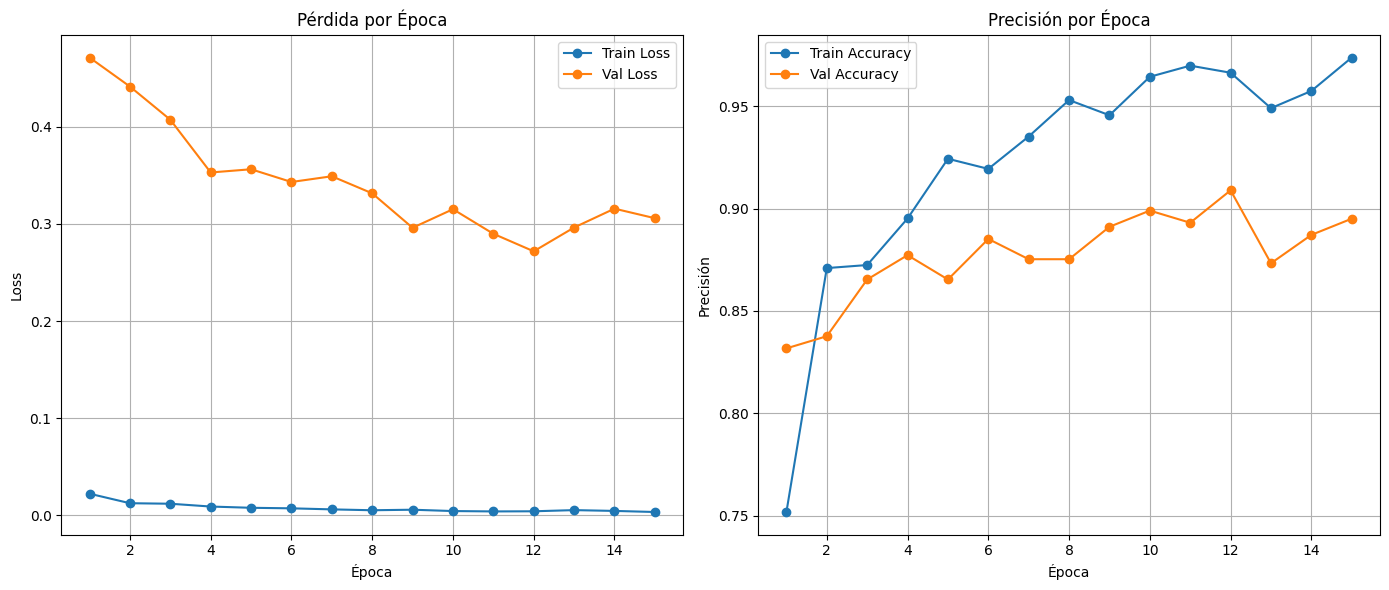

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
get_loss_precision_plots(
    train_losses, val_losses, train_accuracies, val_accuracies, axs[0], axs[1]
)
fig.tight_layout()

Exportación del modelo entrenado.

In [ ]:
os.makedirs("output", exist_ok=True)
torch.save(model.state_dict(), "output/trashnet_efficientnet_b0.pth")

## Conclusiones:

**Resultados para Modelo Resnet (Modelo A)**

 Best trial:

  F1 score: 0.8134532928419761
  Params:
    lr: 0.004367922954598241
    weight_decay: 8.843939602412726e-06
    batch_size: 32
    step_size: 3
    gamma: 0.13565654529804916

**Resultados para EfficientNet-B0 (Modelo B)**

 Best trial:

  Best trial:
  F1 score: 0.8762210943161396
  Params:
    lr: 0.009550666304303759
    weight_decay: 0.0007685471197628106
    batch_size: 32
    step_size: 7
    gamma: 0.6275531729477372

**Resultado final EfficientNet-B0 (Modelo B)**: Epoch 15/15 | Train Loss: 0.0034, Train Acc: 0.9738 | Val Loss: 0.3059, Val Acc: 0.8950

 EfficientNet-B0 (Modelo B) supera a ResNet18 (Modelo A) tanto en precisión (F1) como en eficiencia, a pesar de tener menos parámetros entrenables.

EfficientNet fue diseñada explícitamente para ser eficiente y precisa con menor complejidad computacional.

Ambos modelos están usando feature extraction (congelando parámetros).
Esto es útil si el dataset no es muy grande, pero si hay suficientes datos, se podrian descongelar parcialmente capas intermedias (fine-tuning profundo) para sacar aún más provecho de EfficientNet.

 El mejor desempeño del Modelo B se debe a la arquitectura, no a los hiperparámetros en este caso.


 El modelo EfficientNet-B0 (Modelo B) es superior en términos de F1-score (+7% mejor), lo que indica que generaliza mejor en el conjunto de validación.



EfficientNet-B0 es superior en tareas reales de clasificación, especialmente si buscás mayor precisión con menos recursos computacionales.

ResNet18 sigue siendo una excelente opción cuando querés algo simple, rápido de entrenar y fácil de modificar, ideal para prototipos o cuando la interpretabilidad importa más que la precisión.

Comparación de Modelos

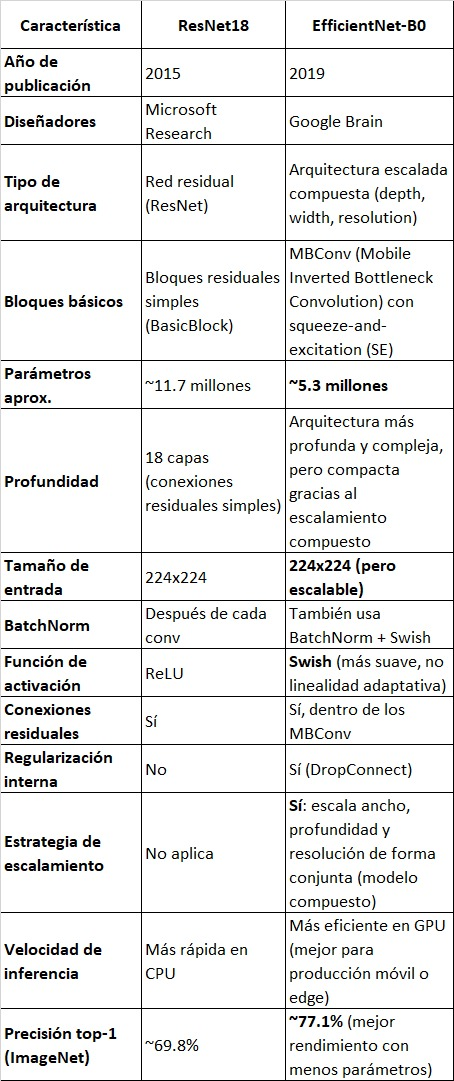